# CNTK 205: 芸術スタイルの転送

このチュートリアルでは、1つの画像のスタイルを別の画像に転送する方法を示します。これにより普通の写真を撮った後に、有名な画像や絵画のスタイルでそれらを描画することができます。

このチュートリアルでは、見栄えの良い写真を作成するのとは別に、学習済みの[VGGモデル](https://arxiv.org/abs/1409.1556)を CNTK にロードする方法、（パラメータではなく）入力変数に対して関数の勾配を得る方法、および CNTK の外部の勾配を使用する方法について学びます.

我々は、[NovacとNikulin](https://arxiv.org/abs/1605.04603)の改善のいくつかと[Gatys ら](https://arxiv.org/abs/1508.06576)のアプローチに従います。より[高速なテクニック](https://arxiv.org/abs/1603.08155)も存在しますが、それらは特定のスタイルの転送に限定されます。

まず、必要なパッケージをインポートします。お馴染みの顔ぶれの ( `numpy` 、 `scipy` 、および `cntk` ) に加えて、画像処理のために `PIL`、学習済みのモデルをダウンロードするために `requests`、学習済みのモデルの重みを読み取るために `h5py` が必要です。

In [1]:
from __future__ import print_function
import numpy as np
from scipy import optimize as opt
import cntk as C
from PIL import Image
import requests
import h5py
import os
%matplotlib inline
import matplotlib.pyplot as plt

import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

学習済みのモデルは、もともと[このページ](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)から得たVGGネットワークです。簡単にダウンロードできるように、ここでホストしています。ローカルにない場合はそれをダウンロードし、numpy 配列に重みをロードします。

In [2]:
def download(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as handle:
        for data in response.iter_content(chunk_size=2**20):
            if data: handle.write(data)


def load_vgg(path):
    f = h5py.File(path)
    layers = []
    for k in range(f.attrs['nb_layers']):
        g = f['layer_{}'.format(k)]
        n = g.attrs['nb_params']
        layers.append([g['param_{}'.format(p)][:] for p in range(n)])
    f.close()
    return layers

# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

path = 'vgg16_weights.bin'
url = 'https://cntk.ai/jup/models/vgg16_weights.bin'
# We check for the model locally
if not os.path.exists(path):
    # If not there we might be running in CNTK's test infrastructure
    if is_test():
        path = os.path.join(os.environ[envvar],'PreTrainedModels','Vgg16','v0',path)
    else:
        #If neither is true we download the file from the web
        print('downloading VGG model (~0.5GB)')
        download(url, path)
layers = load_vgg(path)
print('loaded VGG model')

downloading VGG model (~0.5GB)
loaded VGG model


次に、VGGネットワークを CNTK のグラフとして定義します。

In [17]:
[(x[0].shape, x[1].shape, len(x)) for x in layers if len(x) > 0]

[((64, 3, 3, 3), (64,), 2),
 ((64, 64, 3, 3), (64,), 2),
 ((128, 64, 3, 3), (128,), 2),
 ((128, 128, 3, 3), (128,), 2),
 ((256, 128, 3, 3), (256,), 2),
 ((256, 256, 3, 3), (256,), 2),
 ((256, 256, 3, 3), (256,), 2),
 ((512, 256, 3, 3), (512,), 2),
 ((512, 512, 3, 3), (512,), 2),
 ((512, 512, 3, 3), (512,), 2),
 ((512, 512, 3, 3), (512,), 2),
 ((512, 512, 3, 3), (512,), 2),
 ((512, 512, 3, 3), (512,), 2),
 ((25088, 4096), (4096,), 2),
 ((4096, 4096), (4096,), 2),
 ((4096, 1000), (1000,), 2)]

In [3]:
# A convolutional layer in the VGG network
def vggblock(x, arrays, layer_map, name):
    f = arrays[0]
    b = arrays[1]
    k = C.constant(value=f)
    t = C.constant(value=np.reshape(b, (-1, 1, 1)))
    y = C.relu(C.convolution(k, x, auto_padding=[False, True, True]) + t)
    layer_map[name] = y
    return y

# A pooling layer in the VGG network
def vggpool(x):
    return C.pooling(x, C.AVG_POOLING, (2, 2), (2, 2))


# Build the graph for the VGG network (excluding fully connected layers)
def model(x, layers):
    model_layers = {}
    def convolutional(z): return len(z) == 2 and len(z[0].shape) == 4
    conv = [layer for layer in layers if convolutional(layer)]
    cnt = 0
    num_convs = {1: 2, 2: 2, 3: 3, 4: 3, 5: 3}
    for outer in range(1,6):
        for inner in range(num_convs[outer]):
            x = vggblock(x, conv[cnt], model_layers, 'conv%d_%d' % (outer, 1+inner))
            cnt += 1
        x = vggpool(x)
    
    return x, C.combine([model_layers[k] for k in sorted(model_layers.keys())])

### 損失関数の定義

一連の処理で興味深いのは、最適化すると一方の画像の内容に近く、かつ、他方の画像のスタイルにも近くなるような損失関数の定義です。この損失は、先ほど作成したVGGネットワークで定義されている項が含まれています。具体的には、損失は、候補画像$ x $を取り、以下の3つの項の加重和を取る: コンテンツの損失、スタイルの損失と総変動損失:

$$
L(x) = \alpha C(x) + \beta S(x) + T(x)
$$

ここで、 $ \alpha $と$ \beta $は、それぞれコンテンツの損失とスタイルの損失の重みです。総変動損失の前の重みが1であるように重みを正規化しています。さて、これらの各項はどのように計算されるのでしょうか？

- [総変動損失](https://en.wikipedia.org/wiki/Total_variation_denoising) $T(x)$ は最も理解しやすいです：隣接するピクセル値間の平方差の平均合計を測定し、結果の$ x $を滑らかなイメージにします。これを実装するには、(-1, 1) を含むカーネルで画像を水平および垂直に畳み込み、その結果を二乗し、その平均を計算します。

- コンテンツの損失は、コンテンツイメージと$ x $の二乗差を測定しています。RAW ピクセルまたはVGGネットワーク内のさまざまな層でこの差を測定することができます。コンテンツの損失を単に$ C(x) $として記述しますが、コンテンツのイメージにも暗黙的に依存しています。しかし、イメージは固定されているので、明示的にはこの依存を記述していません。

- スタイル損失の$ S(x) $は、別のイメージに暗黙的に依存する点で、コンテンツの損失に似ています。Gatys らの基本のアイデアは、スタイルをネットワークのアクティベーション間の相関関係として定義し、これらの相関の間の二乗差としてスタイルの損失を測定することでした。特に特定の層については、出力チャンネル間の共分散行列を計算し、すべての位置ついて平均化します。スタイルの損失は、スタイルイメージから導いた共分散行列と、 $ x $から導いた共分散行列の間の二乗誤差にすぎません。ここでは、ネットワークのどの層を使用するかを意図的にあいまいにしています。実装次第ですが、以下ではすべての層のすべてのスタイルの損失の加重合計を使用します。

以下に、これらの損失関数を定義します。

In [4]:
def flatten(x):
    assert len(x.shape) >= 3
    return C.reshape(x, (x.shape[-3], x.shape[-2] * x.shape[-1]))


def gram(x):
    features = C.minus(flatten(x), C.reduce_mean(x))
    return C.times_transpose(features, features)


def npgram(x):
    features = np.reshape(x, (-1, x.shape[-2]*x.shape[-1])) - np.mean(x)
    return features.dot(features.T)


def style_loss(a, b):
    channels, x, y = a.shape
    assert x == y
    A = gram(a)
    B = npgram(b)
    return C.squared_error(A, B)/(channels**2 * x**4)


def content_loss(a,b):
    channels, x, y = a.shape
    return C.squared_error(a, b)/(channels*x*y)


def total_variation_loss(x):
    xx = C.reshape(x, (1,)+x.shape)
    delta = np.array([-1, 1], dtype=np.float32)
    kh = C.constant(value=delta.reshape(1, 1, 1, 1, 2))
    kv = C.constant(value=delta.reshape(1, 1, 1, 2, 1))
    dh = C.convolution(kh, xx, auto_padding=[False])
    dv = C.convolution(kv, xx, auto_padding=[False])
    avg = 0.5 * (C.reduce_mean(C.square(dv)) + C.reduce_mean(C.square(dh)))
    return avg

### 損失のインスタンス化

さて、2つのイメージから損失をインスタンス化する準備が整いました。ここでは、ポートランドの風景とヴァンサン・ヴァン・ゴッホによる[星空の夜](https://en.wikipedia.org/wiki/The_Starry_Night)のイメージを使います。最初に、チューニングパラメータをいくつか定義します。説明は以下です。

- コードが GPU または CPU で実行されるかどうかに応じて、それぞれ 300 x 300 または 64 x 64 に画像のサイズを変更し、プロセスを高速化し、実験が容易になるよう最適化の反復回数を調整します。結果が気に入れば、より大きなサイズを使用してもよいでしょう。もし CPU しかない場合は、しばらく待つ必要があります。
- コンテンツの重みとスタイルの重みは、結果の画像の品質に寄与する重要なパラメータです。
- 減衰係数は区間 (0, 1) の間の数値で、各層の貢献度を決定します。[NovakとNikulin](https://arxiv.org/abs/1605.04603)に従って、すべての層がコンテンツの損失とスタイルの損失の両方に寄与します。コンテンツの損失は、入力層が最も重く、VGGネットワークの各後段の層は、入力から離れるにしたがって指数関数的に小さい重みで寄与しています。スタイルの損失は、VGGネットワークの出力が最も重く、各前段の層は、出力から離れるにしたがって指数関数的に小さい重みで寄与します。NovakとNikulinのように0.5の減衰係数を使用します。
- `inner`と`output`のパラメータは、最終的な結果をどのように取得するかを定義します。 損失を最小限に抑える画像の探索中にスナップショットを`outer` 回、取ります。`inner` ステップの最適化の後、毎回、スナップショットを取ります。
- 最後に、学習済みネットワークについて非常に重要なことは、それが訓練された方法です。特に、トレーニングセット内のすべての入力イメージから、赤、緑、青の各チャンネルの平均値の定数ベクトルが減算されています。これにより入力の中心がゼロとなり、効率的に学習処理を行えます。このベクトルを減算しないと、結果のイメージは、学習用のイメージのようには見えず、悪い結果につながります。このベクトルは以下では`SHIFT`で参照されます。

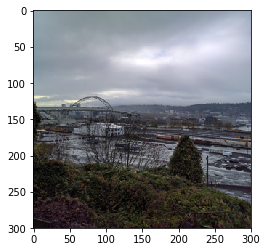

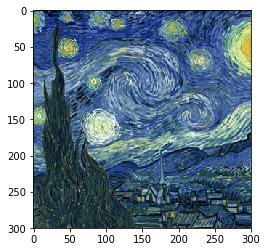

In [5]:
style_path = 'style.jpg'
content_path = 'content.jpg'

start_from_random = False
content_weight = 5.0
style_weight = 1.0
decay = 0.5

if is_test():
    outer = 2
    inner = 2
    SIZE = 64
else:
    outer = 10
    inner = 20
    SIZE = 300

SHIFT = np.reshape([103.939, 116.779, 123.68], (3, 1, 1)).astype('f')

def load_image(path):
    with Image.open(path) as pic:
        hw = pic.size[0] / 2
        hh = pic.size[1] / 2
        mh = min(hw,hh)
        cropped = pic.crop((hw - mh, hh - mh, hw + mh, hh + mh))
        array = np.array(cropped.resize((SIZE,SIZE), Image.BICUBIC), dtype=np.float32)
        return np.ascontiguousarray(np.transpose(array, (2,0,1)))-SHIFT

def save_image(img, path):
    sanitized_img = np.maximum(0, np.minimum(255, img+SHIFT))
    pic = Image.fromarray(np.uint8(np.transpose(sanitized_img, (1, 2, 0))))
    pic.save(path)

def ordered_outputs(f, binding):
    _, output_dict = f.forward(binding, f.outputs)
    return [np.squeeze(output_dict[out]) for out in f.outputs]

# download the images if they are not available locally
for local_path in content_path, style_path:
    if not os.path.exists(local_path):
        download('https://cntk.ai/jup/%s' % local_path, local_path)

# Load the images
style   = load_image(style_path)
content = load_image(content_path)

# Display the images
for img in content, style:
    plt.figure()
    plt.imshow(np.asarray(np.transpose(img+SHIFT, (1, 2, 0)), dtype=np.uint8))

# Push the images through the VGG network 
# First define the input and the output
y = C.input_variable((3, SIZE, SIZE), needs_gradient=True)
z, intermediate_layers = model(y, layers)
# Now get the activations for the two images
content_activations = ordered_outputs(intermediate_layers, {y: [[content]]})
style_activations = ordered_outputs(intermediate_layers, {y: [[style]]})
style_output = np.squeeze(z.eval({y: [[style]]}))

# Finally define the loss
n = len(content_activations)
total = (1-decay**(n+1))/(1-decay) # makes sure that changing the decay does not affect the magnitude of content/style
loss = (1.0/total * content_weight * content_loss(y, content) 
         + 1.0/total * style_weight * style_loss(z, style_output) 
         + total_variation_loss(y))

for i in range(n):
    loss = (loss 
        + decay**(i+1)/total * content_weight * content_loss(intermediate_layers.outputs[i], content_activations[i])
        + decay**(n-i)/total * style_weight   *   style_loss(intermediate_layers.outputs[i], style_activations[i]))

### 損失の最適化

定義された損失を最小限に抑えるイメージを見つける準備が、今、ついに整いました。ここでは、scipy の最適化用のパッケージ、中でも特に LBFGS 法を使用します。LBFGS は全微分の計算が可能な場合に非常によく使われる最適化法です。

入力に関して勾配を計算していることに注意してください。これは、ネットワークパラメータに対して勾配を計算する他のほとんどのユースケースとはまったく異なります。デフォルトでは、入力変数は勾配の計算をされませんが、入力変数は

```python
y = C.input_variable((3, SIZE, SIZE), needs_gradient=True)
```

として定義されているため、CNTK はこの入力変数に対しても勾配を計算します。

コードの残りの部分は簡単であり、複雑さのほとんどは、scipy の最適化パッケージとのやりとりから来ています:

- オプティマイザは倍精度のベクトルでのみ動作するので、img2vec は (3, SIZE, SIZE) の画像を倍精度のベクトルへ変換します。
- CNTK は、画像の入力を必要としますが、scipy は、ベクトルで呼び出ししてきます。
- CNTK は勾配を画像として計算しますが、scipy には、ベクトルの勾配が必要です。

これらの複雑さはあるにせよ、単にコンテンツの画像 (またはランダムな画像) から開始し、最適化を実行し、最終的な結果を表示します。

objective : 52749.3
objective : 44104.2
objective : 42007.4
objective : 41032.5
objective : 40531.3
objective : 40239.9
objective : 40039.2
objective : 39913.7
objective : 39824.6
objective : 39748.0


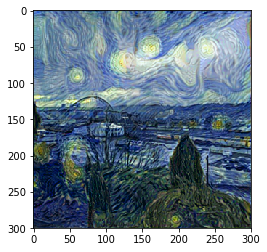

In [6]:
# utility to convert a vector to an image
def vec2img(x):
    d = np.round(np.sqrt(x.size / 3)).astype('i')
    return np.reshape(x.astype(np.float32), (3, d, d))

# utility to convert an image to a vector
def img2vec(img):
    return img.flatten().astype(np.float64)

# utility to compute the value and the gradient of f at a particular place defined by binding
def value_and_grads(f, binding):
    if len(f.outputs) != 1:
        raise ValueError('function must return a single tensor')
    df, valdict = f.forward(binding, [f.output], set([f.output]))
    value = list(valdict.values())[0]
    grads = f.backward(df, {f.output: np.ones_like(value)}, set(binding.keys()))
    return value, grads

# an objective function that scipy will be happy with
def objfun(x, loss):
    y = vec2img(x)
    v, g = value_and_grads(loss, {loss.arguments[0]: [[y]]})
    v = np.reshape(v, (1,))
    g = img2vec(list(g.values())[0])
    return v, g

# the actual optimization procedure
def optimize(loss, x0, inner, outer):
    bounds = [(-np.min(SHIFT), 255-np.max(SHIFT))]*x0.size
    for i in range(outer):
        s = opt.minimize(objfun, img2vec(x0), args=(loss,), method='L-BFGS-B', 
                         bounds=bounds, options={'maxiter': inner}, jac=True)
        print('objective : %s' % s.fun[0])
        x0 = vec2img(s.x)
        path = 'output_%d.jpg' % i
        save_image(x0, path)
    return x0

np.random.seed(98052)
if start_from_random:
    x0 = np.random.randn(3, SIZE, SIZE).astype(np.float32)
else:
    x0 = content
xstar = optimize(loss, x0, inner, outer)
plt.imshow(np.asarray(np.transpose(xstar+SHIFT, (1, 2, 0)), dtype=np.uint8))

In [7]:
# For testing purposes
objfun(xstar, loss)[0][0]

39748.008